In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
import scipy.sparse as sparse
from scipy.sparse.linalg import splu
from scipy import stats

import matplotlib.pyplot as plt

strQx = "CH_qx.txt"
strQy = "CH_qy.txt"
strNx = "CH_bestand.txt"

def ReadDate(strqx,strqy,strbest):
    qxdict = dict() # qx(gender, time, age) returns (qx, nx, dx) # gender 0 man 1 woman
    QxRawData = np.loadtxt(strqx, skiprows=1)
    QyRawData = np.loadtxt(strqy, skiprows=1)
    BestRawData = np.loadtxt(strbest, skiprows=1)
    
    print("Processing Bestand")
    for i in range(len(BestRawData)):
        qxdict[(0,BestRawData[i,0],BestRawData[i,1])] = [None, BestRawData[i,2], None]
        qxdict[(1,BestRawData[i,0],BestRawData[i,1])] = [None, BestRawData[i,3], None]
    
    print("Processing Qx")
    for i in range(len(QxRawData)):
        t = QxRawData[i,0]
        x = QxRawData[i,1]
        qx = QxRawData[i,3]
        Nx = qxdict[(0,t,x)][1] 
        Dx = qx * Nx
        qxdict[(0,t,x)] = [qx, Nx, Dx]
 
    print("Processing Qy")
    for i in range(len(QyRawData)):
        t = QyRawData[i,0]
        x = QyRawData[i,1]
        qx = QyRawData[i,3]
        Nx = qxdict[(1,t,x)][1] 
        Dx = qx * Nx
        qxdict[(1,t,x)] = [qx, Nx, Dx]
    
    return qxdict

QxData = ReadDate(strQx,strQy,strNx)

def QxRaw(age,t,myp, gender =0, tMax=2018):
    # Note use QxData as raw data
    t = min(t,tMax)
    return(QxData[(gender,t,age)][0])

def Qx(age,t, myp):
    # use exp(a+bx+cx^2 + lam * t)
    a=myp[0]
    b=myp[1]
    c=myp[2]
    d=myp[3]
    return(np.exp(a+(b+c*age)*age+t*d))


def Qx2(age,t, myp):
    # 
    t0=myp[0]
    qxt0=myp[1]
    lamb=myp[2]
    return(qxt0[age] * np.exp(lamb[age]*(t-t0)))



def MyErr(a, *symParam):
    #print(a, symParam)
    QxData = symParam[0]
    Times = symParam[1]
    Ages = symParam[2]
    gender = symParam[3]
    Err = 0
    for t in Times:
        for x in Ages:
            #print(x,t,a)
            #print(Qx(x,t,a))
            #print(QxData[(gender,t,x)])
            
            Err += (Qx(x,t, a)- QxData[(gender,t,x)][0])**2
    return Err

def FitMortality(Data,Times,Ages,gender):
    # Data: Moratlity Data
    # Times a subset of times
    # Ages a subset of Ages
    qxp = [-9.13275,8.09432e-2,  -1.1018e-5, -0.01]
    dParam = sp.optimize.fmin(MyErr, qxp, args=(Data,Times,Ages,gender), xtol=0.0001, ftol=0.0001, full_output = True)

    return(dParam)

def PlotResidues(dParam, Data, Times, Ages, filename="residualqx.png"):
    todo
    
    return(strStatisticResiduals)

def BacktestQx(Data, Times, Ages, gender, dT= 10, filename="backtest.png"):
    MyParam = FitMortality(Data,Times,Ages,gender)
    a=dParam[0]
    ProjT = max(Times)+dT
    EffDeath = 0
    ProjectedDeath = 0
    for i in Ages:
        Nx = Data[(gender,ProjT,i)][1] 
        Dx = Data[(gender,ProjT,i)][2] 
        EffDeath += Dx
        ProjectedDeath += Nx * min(1,Qx(i,ProjT, a))
        
    return(EffDeath, ProjectedDeath)
    
def BacktestQx2(Data, Times, Ages, gender, dT= 10, filename="backtest.png"):
    MyParam = FitGT(Data, Times,gender = gender,lam = 100,omega=110,figure=False)
    ProjT = max(Times)+dT
    EffDeath = 0
    ProjectedDeath = 0
    for i in Ages:
        Nx = Data[(gender,ProjT,i)][1] 
        Dx = Data[(gender,ProjT,i)][2] 
        EffDeath += Dx
        ProjectedDeath += Nx * min(1,Qx2(i,ProjT, MyParam))
        
    return(EffDeath, ProjectedDeath)
    

def BacktestQxBestand(Data, Times, Ages, filename="backtestbesta.png"):
    todo
    
    return(strStatisticResiduals)


def speyediff(N, d, format='csc'):
    """
    (utility function)
    Construct a d-th order sparse difference matrix based on 
    an initial N x N identity matrix
    
    Final matrix (N-d) x N
    """
    
    assert not (d < 0), "d must be non negative"
    shape     = (N-d, N)
    diagonals = np.zeros(2*d + 1)
    diagonals[d] = 1.
    for i in range(d):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(d+1)
    spmat = sparse.diags(diagonals, offsets, shape, format=format)
    return spmat


def whittaker_smooth(y, lmbd, d = 2):
    """
    Implementation of the Whittaker smoothing algorithm,
    based on the work by Eilers [1].
    [1] P. H. C. Eilers, "A perfect smoother", Anal. Chem. 2003, (75), 3631-3636
    
    The larger 'lmbd', the smoother the data.
    For smoothing of a complete data series, sampled at equal intervals
    This implementation uses sparse matrices enabling high-speed processing
    of large input vectors
    
    ---------
    
    Arguments :
    
    y       : vector containing raw data
    lmbd    : parameter for the smoothing algorithm (roughness penalty)
    d       : order of the smoothing 
    
    ---------
    Returns :
    
    z       : vector of the smoothed data.
    """

    m = len(y)
    E = sparse.eye(m, format='csc')
    D = speyediff(m, d, format='csc')
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z   

def FitGT(Data, Times,gender = 0,lam = 100,omega=110,figure=True):
    qxt0 = np.zeros(omega)
    t=max(Times)
    for i in range(omega):
        qxt0[i]=Data[(gender,t,i)][0]
    qxt0 = whittaker_smooth(qxt0, lam)
    lamdaraw = np.zeros(omega)
    for i in range(omega):
        myt = []
        qxlog = []
        for t in Times:
            myt.append(t)
            qxlog.append(np.log(max(0.000001,QxData[(gender,t,i)][0])))
        slope, intercept, r_value, p_value, std_err = stats.linregress(myt,qxlog)
        lamdaraw[i] = min(slope,0)

    mylambda = whittaker_smooth(lamdaraw, lam)
    if figure:
        plt.figure(1)
        plt.semilogy(range(omega),qxt0)
        plt.grid(True)
        plt.figure(2)
        plt.plot(range(omega),mylambda)
        plt.grid(True)
    return t, qxt0, mylambda

Processing Bestand
Processing Qx
Processing Qy


Optimization terminated successfully.
         Current function value: 0.012313
         Iterations: 191
         Function evaluations: 339
[ 2.34544649e+01  8.70547812e-02  7.50884047e-05 -1.67917935e-02]
Optimization terminated successfully.
         Current function value: 0.376776
         Iterations: 469
         Function evaluations: 787
(39240.3086083, 40142.27463588568)


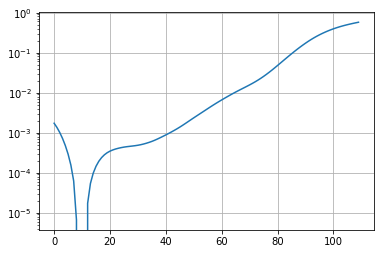

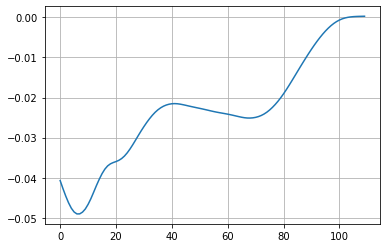

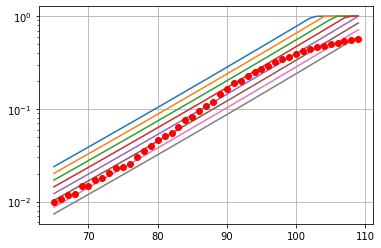

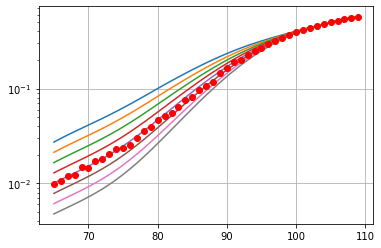

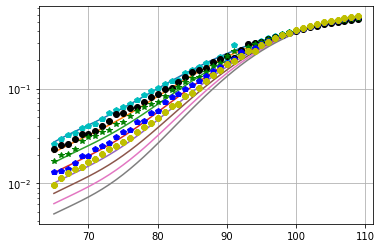

In [2]:
Ages = range(65,86)
Times= range(1975,2015)

dParam = FitMortality(QxData,Times,Ages,0)

a=dParam[0]
modelPar = a

print(a)

b = FitGT(QxData, Times)

Times=range(1975,2046,10)
Times2=range(1975,2018,10)
Ages=range(65,110)

for t in Times:
    x=[]
    y=[]
    for age in Ages:
        x.append(age)
        y.append(min(1,Qx(age,t, a)))
    plt.figure(3)
    plt.semilogy(x,y)
    plt.grid(True)

x=[]
y=[]
for age in Ages:
    x.append(age)
    y.append(QxData[(0,2018,age)][0])
    
plt.figure(3)
plt.semilogy(x,y,'ro')
plt.grid(True)

# Now fow GT Model

for t in Times:
    x=[]
    y=[]
    for age in Ages:
        x.append(age)
        y.append(min(1,Qx2(age,t, b)))
    plt.figure(4)
    plt.semilogy(x,y)
    plt.grid(True)

x=[]
y=[]
for age in Ages:
    x.append(age)
    y.append(QxData[(0,2018,age)][0])
    
plt.figure(4)
plt.semilogy(x,y,'ro')
plt.grid(True)

for t in Times:
    x=[]
    y=[]
    for age in Ages:
        x.append(age)
        y.append(min(1,Qx2(age,t, b)))
    plt.figure(5)
    plt.semilogy(x,y)
    plt.grid(True)

mycols =["cp","ko","g*","bp","y8","cp"]
nn=0
    
for t in Times2:
    x=[]
    y=[]
    for age in Ages:
        x.append(age)
        y.append(QxData[(0,t,age)][0])
    
    plt.figure(5)
    plt.semilogy(x,y,mycols[nn])
    nn+=1
    if nn >= len(mycols):
        nn = 0
    plt.grid(True)

Times= range(1960,2000)
print(BacktestQx(QxData, Times, Ages, 0))


Optimization terminated successfully.
         Current function value: 0.072786
         Iterations: 437
         Function evaluations: 737
Optimization terminated successfully.
         Current function value: 0.070408
         Iterations: 464
         Function evaluations: 786
Optimization terminated successfully.
         Current function value: 0.067534
         Iterations: 468
         Function evaluations: 789
Optimization terminated successfully.
         Current function value: 0.059264
         Iterations: 448
         Function evaluations: 757
Optimization terminated successfully.
         Current function value: 0.049625
         Iterations: 401
         Function evaluations: 671
Optimization terminated successfully.
         Current function value: 0.045736
         Iterations: 457
         Function evaluations: 767
Optimization terminated successfully.
         Current function value: 0.046943
         Iterations: 396
         Function evaluations: 672
Optimization termina

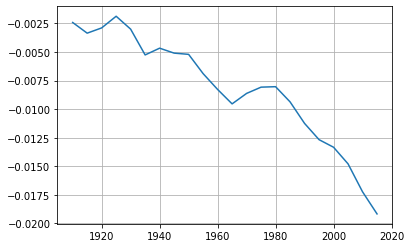

In [36]:
import matplotlib.pyplot as plt

Ages = range(65,86)
T=[]
L=[]
for t in range(1910,2019,5):
    Times= range(t-30,t)
    dParam = FitMortality(QxData,Times,Ages,0)
    T.append(t)
    L.append(dParam[0][3])
    
plt.figure(1)
plt.plot(T,L)
plt.grid(True)



Optimization terminated successfully.
         Current function value: 0.255817
         Iterations: 449
         Function evaluations: 757
Optimization terminated successfully.
         Current function value: 0.217824
         Iterations: 444
         Function evaluations: 762
Optimization terminated successfully.
         Current function value: 0.229342
         Iterations: 427
         Function evaluations: 718
Optimization terminated successfully.
         Current function value: 0.247215
         Iterations: 439
         Function evaluations: 739
Optimization terminated successfully.
         Current function value: 0.261531
         Iterations: 421
         Function evaluations: 707
Optimization terminated successfully.
         Current function value: 0.198376
         Iterations: 445
         Function evaluations: 766
Optimization terminated successfully.
         Current function value: 0.155580
         Iterations: 401
         Function evaluations: 676
Optimization termina

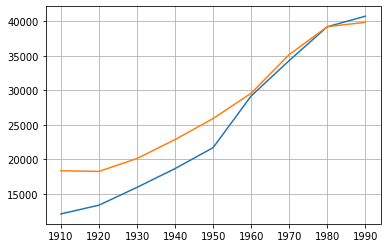

In [56]:
Ages = range(65,100)
x =[]
y1=[]
y2=[]

for t in range(1910,2000,10):
    Times= range(t-30,t)
    d1, d2 = BacktestQx(QxData, Times, Ages, 0)
    x.append(t)
    y1.append(d1)
    y2.append(d2)
    
plt.figure(2)
plt.plot(x,y1,x,y2)
plt.grid(True)

t = 1910
Optimization terminated successfully.
         Current function value: 0.255817
         Iterations: 449
         Function evaluations: 757
 ..... 12095.256943099997 18349.60131489444
t = 1911
Optimization terminated successfully.
         Current function value: 0.255098
         Iterations: 375
         Function evaluations: 646
 ..... 11706.518683000002 18121.874522260478
t = 1912
 ..... 11150.923575499997 18057.02430773694
t = 1913
 ..... 12102.9704819 17977.85851949689
t = 1914
 ..... 11101.694338199999 18012.23584455087
t = 1915
 ..... 12029.713662500002 18061.376704057267
t = 1916
 ..... 12031.6992291 18103.276120304425
t = 1917
 ..... 11626.879690199998 18249.548872375988
t = 1918
Optimization terminated successfully.
         Current function value: 0.231605
         Iterations: 381
         Function evaluations: 646
 ..... 12602.043956000003 18241.032456462963
t = 1919
Optimization terminated successfully.
         Current function value: 0.238695
         Iterations

Optimization terminated successfully.
         Current function value: 0.242090
         Iterations: 373
         Function evaluations: 623
 ..... 26725.6372632 28012.302073977615
t = 1957
 ..... 26784.948860499993 28368.266428478448
t = 1958
Optimization terminated successfully.
         Current function value: 0.199699
         Iterations: 366
         Function evaluations: 622
 ..... 26873.625114600003 28814.89700338301
t = 1959
Optimization terminated successfully.
         Current function value: 0.199757
         Iterations: 461
         Function evaluations: 786
 ..... 28654.141604799992 29197.429586739105
t = 1960
Optimization terminated successfully.
         Current function value: 0.198376
         Iterations: 445
         Function evaluations: 766
 ..... 29175.159682200007 29576.4674049318
t = 1961
Optimization terminated successfully.
         Current function value: 0.193699
         Iterations: 448
         Function evaluations: 757
 ..... 29033.918046400006 30008.103302

 ..... 39635.559204699995 40135.63270897775
t = 2004
Optimization terminated successfully.
         Current function value: 0.115563
         Iterations: 458
         Function evaluations: 765
 ..... 40146.8288255 40253.560268812325


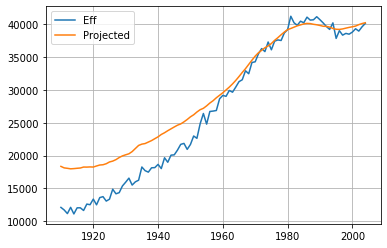

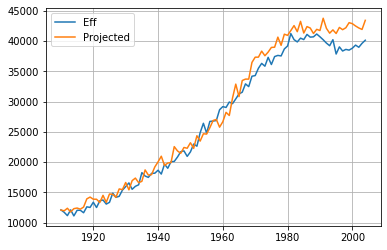

In [122]:
Ages = range(65,100)
x =[]
y1=[]
y2=[]

for t in range(1910,2005,1):
    print("t =",t)
    Times= range(t-30,t)
    d1, d2 = BacktestQx(QxData, Times, Ages, 0)
    print( " .....",d1, d2)
    x.append(t)
    y1.append(d1)
    y2.append(d2)
    
plt.figure(3)
plt.plot(x,y1,x,y2)
plt.grid(True)
plt.legend(["Eff","Projected"])
plt.savefig("errproj.png",dpi=300,papertype="a4",orientation='landscape')

Ages = range(65,100)
x =[]
y1=[]
y2=[]

for t in range(1910,2005,1):
    Times= range(t-30,t)
    d1, d2 = BacktestQx2(QxData, Times, Ages, 0)
    x.append(t)
    y1.append(d1)
    y2.append(d2)
    
plt.figure(4)
plt.plot(x,y1,x,y2)
plt.grid(True)
plt.legend(["Eff","Projected"])
plt.savefig("errprojQx2.png",dpi=300,papertype="a4",orientation='landscape')




t = 1910
Optimization terminated successfully.
         Current function value: 0.255817
         Iterations: 449
         Function evaluations: 757
 ..... 13362.123751500003 18249.526961268108
t = 1915
 ..... 13348.670696500001 19023.60686241885
t = 1920
Optimization terminated successfully.
         Current function value: 0.217824
         Iterations: 444
         Function evaluations: 762
 ..... 15940.715356899998 20117.65204644958
t = 1925
 ..... 18256.104295699995 21744.518803648905
t = 1930
Optimization terminated successfully.
         Current function value: 0.229342
         Iterations: 427
         Function evaluations: 718
 ..... 18655.767052099996 22859.117884865595
t = 1935
Optimization terminated successfully.
         Current function value: 0.232544
         Iterations: 448
         Function evaluations: 754
 ..... 20107.973407999994 24360.063184384042
t = 1940
Optimization terminated successfully.
         Current function value: 0.247215
         Iterations: 439
    

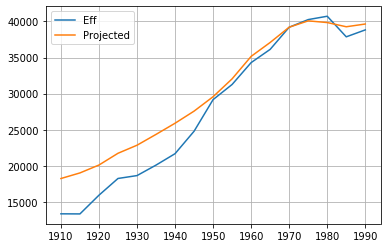

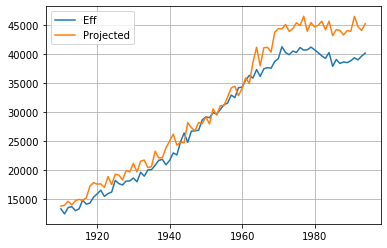

In [124]:
Ages = range(65,100)
x =[]
y1=[]
y2=[]

for t in range(1910,1995,5):
    print("t =",t)
    Times= range(t-30,t)
    d1, d2 = BacktestQx(QxData, Times, Ages, 0,dT= 20)
    print( " .....",d1, d2)
    x.append(t)
    y1.append(d1)
    y2.append(d2)
    
plt.figure(44)
plt.plot(x,y1,x,y2)
plt.grid(True)
plt.legend(["Eff","Projected"])
plt.savefig("errprojt=20.png",dpi=300,papertype="a4",orientation='landscape')

Ages = range(65,100)
x =[]
y1=[]
y2=[]

for t in range(1910,1995,1):
    Times= range(t-30,t)
    d1, d2 = BacktestQx2(QxData, Times, Ages, 0,dT= 20)
    x.append(t)
    y1.append(d1)
    y2.append(d2)
    
plt.figure(45)
plt.plot(x,y1,x,y2)
plt.grid(True)
plt.legend(["Eff","Projected"])
plt.savefig("errprojQx2t=20.png",dpi=300,papertype="a4",orientation='landscape')





t = 1910
Optimization terminated successfully.
         Current function value: 0.255817
         Iterations: 449
         Function evaluations: 757
 ..... 15940.715356899998 20117.65204644958
t = 1911
Optimization terminated successfully.
         Current function value: 0.255098
         Iterations: 375
         Function evaluations: 646
 ..... 16559.619779999997 20271.29009943604
t = 1912
 ..... 15502.839376499996 20606.104160026054
t = 1913
 ..... 15995.373628100002 21078.452948408783
t = 1914
 ..... 16246.631260200002 21549.306096008364
t = 1915
 ..... 18256.104295699995 21744.518803648905
t = 1916
 ..... 17697.752156000002 21833.92600655853
t = 1917
 ..... 17472.4682223 22060.178864424666
t = 1918
Optimization terminated successfully.
         Current function value: 0.231605
         Iterations: 381
         Function evaluations: 646
 ..... 18136.551904200005 22286.37443342449
t = 1919
Optimization terminated successfully.
         Current function value: 0.238695
         Itera

 ..... 37636.91889530001 37978.559500014104
t = 1958
Optimization terminated successfully.
         Current function value: 0.199699
         Iterations: 366
         Function evaluations: 622
 ..... 37549.604661900004 38423.37080612144
t = 1959
Optimization terminated successfully.
         Current function value: 0.199757
         Iterations: 461
         Function evaluations: 786
 ..... 38702.0329946 38832.059678961385
t = 1960
Optimization terminated successfully.
         Current function value: 0.198376
         Iterations: 445
         Function evaluations: 766
 ..... 39195.98378419999 39202.72648696835
t = 1961
Optimization terminated successfully.
         Current function value: 0.193699
         Iterations: 448
         Function evaluations: 757
 ..... 41247.51859699999 39384.20991329909
t = 1962
Optimization terminated successfully.
         Current function value: 0.187925
         Iterations: 439
         Function evaluations: 754
 ..... 40245.45092460001 39585.7408245169

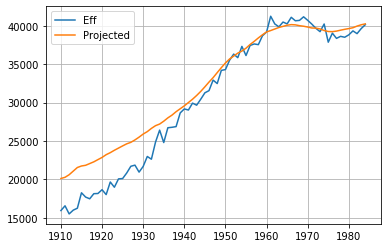

In [64]:
Ages = range(65,100)
x =[]
y1=[]
y2=[]

for t in range(1910,1985,1):
    print("t =",t)
    Times= range(t-30,t)
    d1, d2 = BacktestQx(QxData, Times, Ages, 0,dT= 30)
    print( " .....",d1, d2)
    x.append(t)
    y1.append(d1)
    y2.append(d2)
    
plt.figure(4)
plt.plot(x,y1,x,y2)
plt.grid(True)
plt.legend(["Eff","Projected"])
plt.savefig("errprojt-30.png",dpi=300,papertype="a4",orientation='landscape')

In [70]:
inforce =[]
inforce.append([34,107.823529411765])
inforce.append([35,37.2352941176471])
inforce.append([36,470.823529411765])
inforce.append([37,614.470588235294])
inforce.append([38,0])
inforce.append([39,215.117647058824])
inforce.append([40,450.176470588235])
inforce.append([41,0])
inforce.append([42,0])
inforce.append([43,21.8823529411765])
inforce.append([44,0])
inforce.append([45,467.941176470588])
inforce.append([46,275.764705882353])
inforce.append([47,0])
inforce.append([48,0])
inforce.append([49,852])
inforce.append([50,56.5882352941176])
inforce.append([51,851.411764705882])
inforce.append([52,1990.88235294118])
inforce.append([53,3235])
inforce.append([54,2125.05882352941])
inforce.append([55,9757.23529411765])
inforce.append([56,5879.17647058824])
inforce.append([57,47440.5294117647])
inforce.append([58,41382.1764705882])
inforce.append([59,110756.588235294])
inforce.append([60,151523.529411765])
inforce.append([61,186621])
inforce.append([62,372512.705882353])
inforce.append([63,369683.470588235])
inforce.append([64,952128.058823529])
inforce.append([65,869999.529411765])
inforce.append([66,843489.235294118])
inforce.append([67,738997.235294118])
inforce.append([68,702868.941176471])
inforce.append([69,671977.705882353])
inforce.append([70,608983])
inforce.append([71,587646.470588235])
inforce.append([72,565182.470588235])
inforce.append([73,512445.647058823])
inforce.append([74,499299.294117647])
inforce.append([75,458701.352941176])
inforce.append([76,426997.235294118])
inforce.append([77,377909.176470588])
inforce.append([78,346991.352941176])
inforce.append([79,255619.941176471])
inforce.append([80,226238.117647059])
inforce.append([81,193005.529411765])
inforce.append([82,130670.488888889])
inforce.append([83,91813.9111111111])
inforce.append([84,105588.666666667])
inforce.append([85,85174.8444444444])
inforce.append([86,66784.9333333333])
inforce.append([87,71423.4222222222])
inforce.append([88,42307.3777777778])
inforce.append([89,24125.6])
inforce.append([90,20622.1333333333])
inforce.append([91,16020.6222222222])
inforce.append([92,14808.7111111111])
inforce.append([93,9083.24444444444])
inforce.append([94,4743.02222222222])
inforce.append([95,3488.71111111111])
inforce.append([96,6031.86666666667])
inforce.append([97,4036.62222222222])
inforce.append([98,2742.31111111111])

for i in range(len(inforce)):
    # Note effective inforce 17x bigger
    inforce[i][1] *= 17.
    

In [81]:
def ax(x,param,irate=0.02,omega=110, t0=2020, Qx = Qx):
    ax = 0
    v = 1./(1.+irate)
    for i in range(omega,x-1,-1):
        ax = 1 + ax * v * (1- Qx(i,t0+i-x, param))
    return(ax)

def cf(x,param,omega=110, t0=2020, Qx= Qx):
    cf =np.zeros(omega)
    px = 1.
    for i in range(x, omega):
        cf[i-x] =px
        px *= (1-Qx(i,t0+i-x, param))
    return(cf)

def ValueInforce(inforce,param,irate=0.02,omega=110, t0=2020,Qx=Qx):
    Vx = 0
    R = 0
    CF = np.zeros(omega)
    for i in inforce:
        R += i[1]
        Vx += i[1] * ax(i[0],param,irate=irate,omega=omega, t0=t0,Qx=Qx)
        CF += i[1] * cf(i[0],param,omega=omega, t0=t0,Qx=Qx)
    return(R, Vx, CF)

Res =ValueInforce(inforce,modelPar)
print("MR = ", Res[0:2])

    

MR =  (201369681.31111112, 2929432658.2103944)


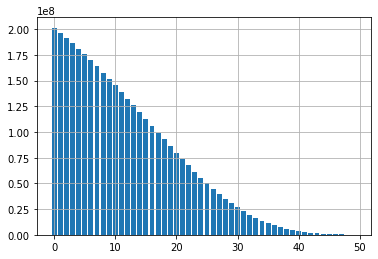

In [77]:
plt.figure(5)
T=range(0,50)
plt.bar(T,Res[2][T])
plt.grid(True)

889602179.7338264


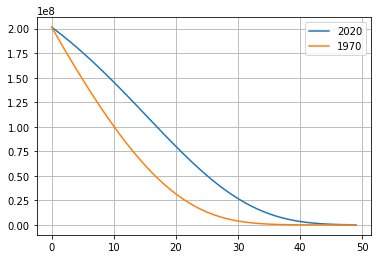

In [83]:
Res70 =ValueInforce(inforce,modelPar,t0=1970)
plt.figure(6)
T=range(0,50)
plt.plot(T,Res[2][T],T,Res70[2][T])
plt.grid(True)
plt.legend(["2020","1970"])

print((Res[1]-Res70[1]))

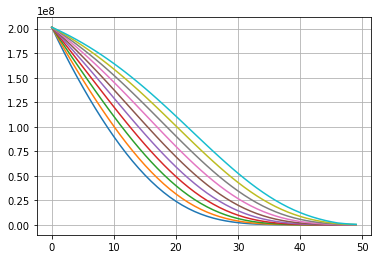

In [85]:
plt.figure(6)
T=range(0,50)
for i in range(1960,2060,10):
    ResX =ValueInforce(inforce,modelPar,t0=i)
    plt.plot(T,ResX[2][T])
plt.grid(True)

Optimization terminated successfully.
         Current function value: 0.034518
         Iterations: 197
         Function evaluations: 355
46126465.60211468


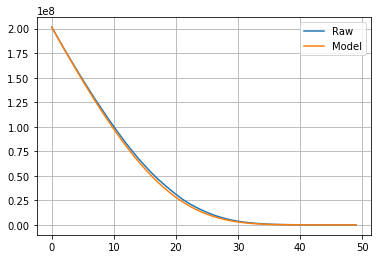

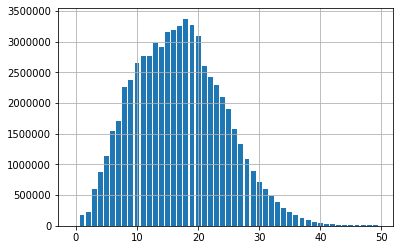

In [104]:
tMeasure = 1970
Ages = range(65,86)
Times= range(tMeasure-40,tMeasure)

dParam = FitMortality(QxData,Times,Ages,0)
a=dParam[0]
modelParM = a

ResM =ValueInforce(inforce,modelParM,t0=tMeasure)
ResMRaw =ValueInforce(inforce,modelPar,t0=tMeasure,Qx=QxRaw)
plt.figure(7)
T=range(0,50)
plt.plot(T,ResMRaw[2][T],T,ResM[2][T])
plt.grid(True)
plt.legend(["Raw","Model"])

print((ResMRaw[1]-ResM[1]))

plt.figure(8)
T=range(0,50)
plt.bar(T,ResMRaw[2][T]-ResM[2][T])
plt.grid(True)


In [90]:
print(QxRaw(50,2010))

0.00277
